# EM Acceleration Methods In GMM

In [113]:
# Imports + global config
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import binom
import time 

# for numerical stability
from scipy.special import logsumexp

# Reproducibility
np.random.seed(12345)


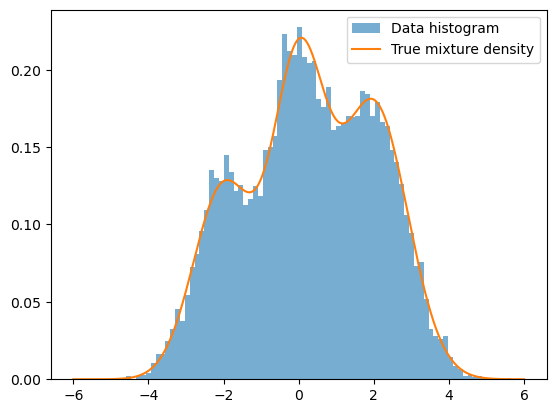

In [121]:
# Cell 2 — Data generation (clearly multimodal, still overlapping)

def Density(y):
    return (
        0.25 * norm.pdf(y, loc=-2.0, scale=0.8) +
        0.35 * norm.pdf(y, loc=0.0,  scale=0.7) +
        0.40 * norm.pdf(y, loc=2.0,  scale=0.9)
    )

n = 10000

pi_true = np.array([0.25, 0.35, 0.40])
mu_true = np.array([-2.0, 0.0, 2.0])
sigma_true = np.array([0.8, 0.7, 0.9])

# Sample component labels
Z = np.random.choice(len(pi_true), size=n, p=pi_true)

# Generate observations
Y = np.zeros(n)
for i in range(n):
    k = Z[i]
    Y[i] = norm.rvs(loc=mu_true[k], scale=sigma_true[k])

# Plot histogram and true density
xgrid = np.linspace(-6, 6, 2000)
plt.hist(Y, bins=80, density=True, alpha=0.6, label="Data histogram")
plt.plot(xgrid, Density(xgrid), label="True mixture density")
plt.legend()
plt.show()


Note: There is a lot of overlap between the two Gaussian components, which is exactly the regime where EM tends to converge slowly and where acceleration methods like SQUAREM are most useful. 

In [122]:
"""Observed log-likelihood for a Gaussian mixture
(We need a function for the observed log-likelihood of
the data under the current model to show that it's increasing.
For SQUAREM, we want to reject updates that decrease the log-likelihood)"""

def obs_log_like(y, mu, var, prop):
    """
    y: observed data, shape (n,)
    GMM params:
        mu   : component means, shape (K,)
        var  : component variances, shape (K,)
        prop : mixing proportions, shape (K,)
    """
    n = len(y) #number of data points
    K = len(mu) #number of components

    # mixture density for each data point
    dens = np.zeros((n, K))
    for k in range(K):
        dens[:, k] = prop[k] * norm.pdf(y, loc=mu[k], scale=np.sqrt(var[k]))

    # sum over components, then log and sum over observations
    return np.sum(np.log(np.sum(dens, axis=1)))


def obs_log_like_stable(y, mu, var, prop):
    """
    Numerically stable version using log-sum-exp.
    Avoids underflow when component densities are very small.
    """
    y = np.asarray(y)
    mu = np.asarray(mu)
    var = np.asarray(var)
    prop = np.asarray(prop)

    # log N(y_i | mu_k, var_k) ---- VECTORIZED
    log_pdf = (
        -0.5 * np.log(2 * np.pi * var)
        - 0.5 * (y[:, None] - mu[None, :])**2 / var[None, :]
    )

    # log of the mixture density
    log_weighted = log_pdf + np.log(prop)

    #logsumexp sums over components, then we sum over observations
    return np.sum(logsumexp(log_weighted, axis=1))

In [123]:
# E-step (responsibilities)
# The Q-function is the expected conditional complete-data log-likelihood,
# where we condition on the posterior distribution of the latent variables (missing data)
# In our case, the missing data is the group assignment of each data point, which we denote as Z
# Thus, the posterior P(Z|Y, current params) is the responsibility matrix resp
# where resp denotes the posterior probability of the group assignment of each data point
# the resp matrix shape is (n, K) ie num_data_points x num_components
# resp[i, k] = P(Z_i = k | y_i, current params)
# we use this matrix (via Bayes' rule) to compute the expected conditional complete-data log-likelihood
# which is the Q-function

def e_step_resp(y, mu, var, prop):
    """
    This function uses Bayes' rule to compute the posterior probability of the group assignment of each data point
    returns:
      resp: (n, K) array where each row sums to 1
    """
    n = len(y)
    K = len(mu)

    resp = np.zeros((n, K))

    # For each component k, compute unnormalized responsibilities:
    # resp[:, k] ∝ prop[k] * N(y | mu[k], var[k])
    for k in range(K):
        resp[:, k] = norm.pdf(y, loc=mu[k], scale=np.sqrt(var[k])) * prop[k]

    # Normalize across components so each row sums to 1 (denominator in Bayes' rule)
    row_sums = np.sum(resp, axis=1, keepdims=True)  # (n, 1)
    resp = resp / row_sums

    return resp


In [124]:
# M-step (fixed point parameter updates)
# Given responsibilities resp, update mixture parameters:
#   prop_k = (1/n) * sum_i resp[i,k]
#   mu_k   = sum_i resp[i,k] * y_i / sum_i resp[i,k]
#   var_k  = sum_i resp[i,k] * (y_i - mu_k)^2 / sum_i resp[i,k]

def m_step_update(y, resp):
    """
    This function uses the calculated posterior responsibilities to update the mixture parameters
    y:    (n,) array of observations
    resp: (n, K) responsibilities from E-step
    returns:
      prop_new: (K,) updated mixing proportions
      mu_new:   (K,) updated means
      var_new:  (K,) updated variances
    """
    n = len(y)
    K = resp.shape[1]

    # N_k = sum_i resp[i,k]
    #Nk := the number of data points assigned to each component (membership count per component)
    Nk = np.sum(resp, axis=0)  # (K,)

    # Update proportions
    prop_new = Nk / n  # (K,)

    # Update means
    mu_new = np.zeros(K)
    for k in range(K):
        mu_new[k] = np.sum(resp[:, k] * y) / Nk[k]

    # Update variances
    var_new = np.zeros(K)
    for k in range(K):
        var_new[k] = np.sum(resp[:, k] * (y - mu_new[k])**2) / Nk[k]

    return prop_new, mu_new, var_new


In [125]:
# Full EM loop (E-step + M-step + log-likelihood trace)

def em_gmm_1d(y, K, mu_init, var_init, prop_init, max_iter=2000, tol=1e-6):
    """
    EM for 1D Gaussian mixture.

    Inputs
    - y:         (n,) data
    - K:         number of mixture components
    - mu_init:   (K,) initial means
    - var_init:  (K,) initial variances
    - prop_init: (K,) initial mixing proportions (sum to 1)
    - max_iter:  max iterations
    - tol:       stopping tolerance on absolute log-likelihood increase

    Returns a dict with final params + traces.
    """
    n = len(y) #number of data points

    # traces (store every iterate so you can plot later)
    mu_trace = [mu_init.copy()]
    var_trace = [var_init.copy()]
    prop_trace = [prop_init.copy()]
    ll_trace = [obs_log_like_stable(y=y, mu=mu_init, var=var_init, prop=prop_init)]

    # main EM iterations
    for t in range(max_iter):
        # Current parameters
        mu_t = mu_trace[-1]
        var_t = var_trace[-1]
        prop_t = prop_trace[-1]

        # ---- E-step ----
        resp = e_step_resp(y=y, mu=mu_t, var=var_t, prop=prop_t)  # (n, K)

        # ---- M-step ----
        prop_new, mu_new, var_new = m_step_update(y=y, resp=resp)

        # Store new parameters
        prop_trace.append(prop_new.copy())
        mu_trace.append(mu_new.copy())
        var_trace.append(var_new.copy())

        # Compute observed log-likelihood at new params (monitoring only)
        ll_new = obs_log_like(y=y, mu=mu_new, var=var_new, prop=prop_new)
        ll_trace.append(ll_new)

        # Check convergence
        increase = abs(ll_trace[-1] - ll_trace[-2])
        if increase < tol:
            break

    # Final outputs
    return {
        "means": mu_trace[-1],
        "vars": var_trace[-1],
        "prop": prop_trace[-1],
        "resp": resp,  # from last E-step
        "iter": len(ll_trace) - 1,
        "tol": increase,
        "trace": {
            "means": mu_trace,
            "vars": var_trace,
            "prop": prop_trace,
            "obs_loglike": ll_trace,
        },
    }


Iterations: 806
Final tol (abs ll increase): 9.930710803018883e-06
Final means: [-0.06767236 -2.00439054  1.91452065]
Final vars: [0.42198649 0.63146662 0.87991436]
Final props: [0.31947784 0.25669727 0.42382489]
Elapsed time: 1.1231362920079846 seconds


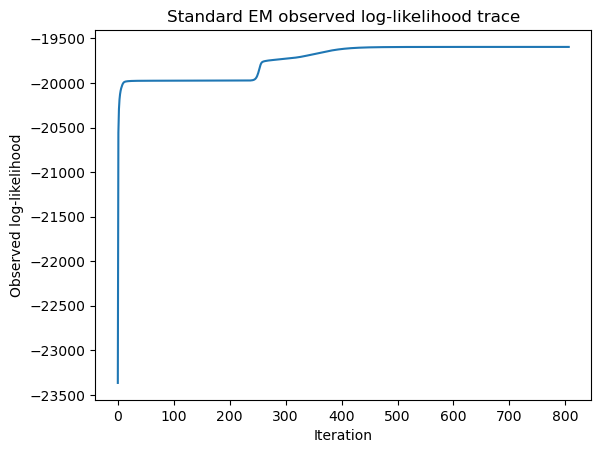

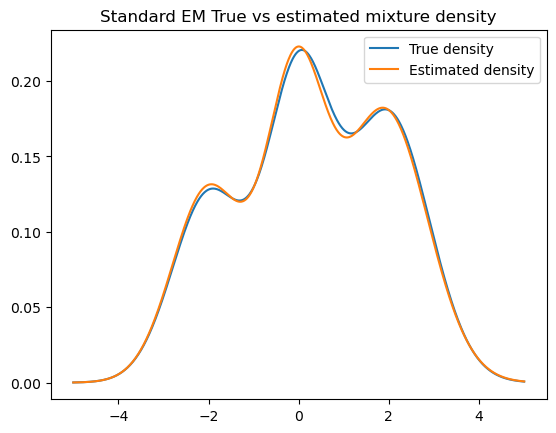

In [151]:
# Run EM + create plots (log-likelihood trace, fitted density vs true density)

# Fit the 2-component mixture
start = time.perf_counter()
fit = em_gmm_1d(
    y=Y,
    K=3,
    mu_init=np.array([0, 0.1, 1]),
    var_init=np.array([0.1, 0.2, 1]),
    prop_init=np.array([0.5, 0.5, 1]),
    tol=1e-5,
    max_iter=2000
)
end = time.perf_counter()

# Quick sanity prints
print("Iterations:", fit["iter"])
print("Final tol (abs ll increase):", fit["tol"])
print("Final means:", fit["means"])
print("Final vars:", fit["vars"])
print("Final props:", fit["prop"])
print(f"Elapsed time: {end - start} seconds")

# 1) Plot log-likelihood trace
plt.figure()
plt.plot(fit["trace"]["obs_loglike"])
plt.xlabel("Iteration")
plt.ylabel("Observed log-likelihood")
plt.title("Standard EM observed log-likelihood trace")
plt.show()

# Plot fitted density vs true density
def est_density_grid(xgrid, fit_dict):
    mu = fit_dict["means"]
    var = fit_dict["vars"]
    prop = fit_dict["prop"]
    # mixture density on a grid
    out = np.zeros_like(xgrid, dtype=float)
    #we loop over mixture components and sum the densities
    #out(x)=π1* ​N(x; μ1​,σ1^2​) + π2*​N(x; μ2​,σ2^2​)
    for k in range(len(mu)):
        out += prop[k] * norm.pdf(xgrid, loc=mu[k], scale=np.sqrt(var[k]))
    return out

plt.figure()
plt.plot(yvalues, Density(yvalues), label="True density")
plt.plot(yvalues, est_density_grid(yvalues, fit), label="Estimated density")
plt.legend()
plt.title("Standard EM True vs estimated mixture density")
plt.show()


# SQUAREM accelerated EM 

SQUAREM Iterations: 70
SQUAREM Final tol (abs ll increase): 6.612415745621547e-06
SQUAREM Final means: [-0.06743081 -2.0051138   1.91549909]
SQUAREM Final vars: [0.42298156 0.63094998 0.87906295]
SQUAREM Final props: [0.31999421 0.2565142  0.42349159]
SQUAREM Elapsed time: 0.2764561250223778 seconds


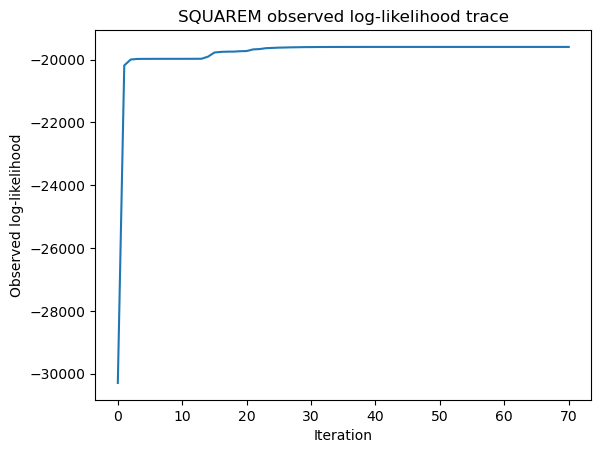

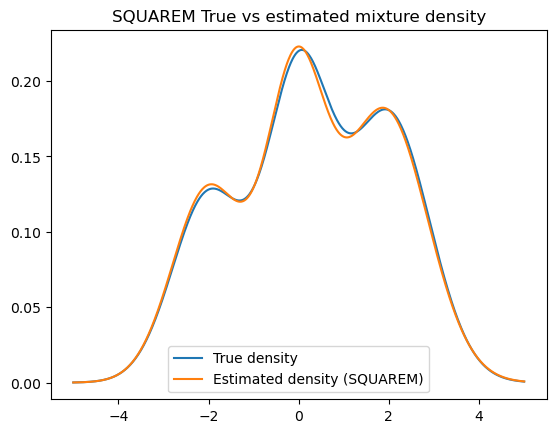

In [153]:
# SQUAREM-accelerated EM (wrapper around the same E-step + M-step)

def squarem_gmm_1d(y, K, mu_init, var_init, prop_init, max_iter=2000, tol=1e-6, max_backtrack=20):
    """
    SQUAREM acceleration for 1D Gaussian mixture EM.

    Key idea:
      - Treat one EM iteration as a mapping M(theta).
      - Use two EM applications to build Δtheta and Δ^2 theta.
      - Extrapolate, then map back through M(.) to preserve stability.

    Returns a dict with final params + traces (same style as em_gmm_1d).
    """

    # --- helpers to pack/unpack parameters into a single vector ---
    # we need this since SQUAREM math requires a single vector of parameters
    # whereas EM steps require separate vectors for mu, var, prop
    def pack_theta(mu, var, prop):
        return np.concatenate([mu, var, prop])  # shape (3K,)

    def unpack_theta(theta):
        mu = theta[0:K]
        var = theta[K:2*K]
        prop = theta[2*K:3*K]
        return mu, var, prop

    def normalize_params(mu, var, prop):
        # keep variances positive and proportions valid
        # SQUAREM is just an extrapolated vector of parameters, 
        # it doesn't guarantee that the parameters are valid in GMM context
        # so we need to normalize them and ensure they are valid
        # note that the normalization step is a safeguard, rather than the final estimator
        # we still do theta_next = M(tilde_theta) ie run EM on the extrapolated vector
        # The EM mapping pulls parameters back toward a likelihood-increasing direction
        # ensures that we have a valid EM step.
        # Essentially, because SQUAREM performs unconstrained vector extrapolation in the ambient
        # parameter space, a normalization step is required to ensure that variances remain 
        # positive and mixing proportions remain valid probabilities before applying the EM mapping. 
        var = np.maximum(var, 1e-12)
        prop = np.maximum(prop, 1e-15)
        prop = prop / np.sum(prop)
        return mu, var, prop

    # --- the EM mapping M(theta): one E-step + one M-step ---
    # this is the function that takes a single vector of parameters, 
    # performs one EM iteration, and returns a new vector of parameters. 
    # it is the last step of the SQUAREM iteration, where we map back 
    # through M(.) to preserve stability. 
    def em_map(theta_vec):
        mu, var, prop = unpack_theta(theta_vec)
        # normalize parameters to ensure they are valid (since theta_vec is unconstrained)
        mu, var, prop = normalize_params(mu, var, prop)
        # perform one EM iteration
        resp = e_step_resp(y=y, mu=mu, var=var, prop=prop)
        prop_new, mu_new, var_new = m_step_update(y=y, resp=resp)
        # note: this second normalization is not theoretically required, but it is a safeguard
        # to ensure that the parameters are valid in case of numerical rounding errors. 
        mu_new, var_new, prop_new = normalize_params(mu_new, var_new, prop_new)
        return pack_theta(mu_new, var_new, prop_new)

    # --- initialize ---
    mu0 = np.asarray(mu_init, dtype=float).copy()
    var0 = np.asarray(var_init, dtype=float).copy()
    prop0 = np.asarray(prop_init, dtype=float).copy()
    # normalize to insure initial parameters are valid
    mu0, var0, prop0 = normalize_params(mu0, var0, prop0)
    # pack initial parameters into a single vector for SQUAREM extrapolation
    theta = pack_theta(mu0, var0, prop0)

    # traces (store every accepted iterate so you can plot later)
    mu_trace = [mu0.copy()]
    var_trace = [var0.copy()]
    prop_trace = [prop0.copy()]
    ll_trace = [obs_log_like_stable(y=y, mu=mu0, var=var0, prop=prop0)]

    # main SQUAREM iterations
    for t in range(max_iter):
        # (article): psi0 = theta, psi1 = M(psi0), psi2 = M(psi1)
        psi0 = theta
        psi1 = em_map(psi0)
        psi2 = em_map(psi1)

        # Δpsi0 (difference between iterations) and Δ^2psi0 (difference between differences)
        d1 = psi1 - psi0
        d2 = psi2 - 2.0 * psi1 + psi0

        # choose alpha (Eq. (40) in the article)
        norm_d1 = np.linalg.norm(d1)
        norm_d2 = np.linalg.norm(d2)

        # if d2 is ~0, fall back to a regular EM step since then the extrapolation is not reliable
        # ie alpha is not well-defined since alpha = - norm_d1 / norm_d2
        if norm_d2 < 1e-14 or norm_d1 < 1e-14:
            theta_next = psi1  # regular EM
        else:
            alpha = - norm_d1 / norm_d2  # negative step length (Eq. 40)

            # modify alpha (article safeguard)
            # If alpha > -1, set alpha = -1 
            # This is a safeguard to ensure that the step length is not too large
            # and that the extrapolation is not too aggressive (FROM ARTICLE) 
            if alpha > -1.0:
                alpha = -1.0

            # extrapolated point epsi(alpha) = psi0 - 2a*d1 + a^2*d2
            # We backtrack on alpha until log-likelihood improves (relative to psi0).
            ll_psi0 = ll_trace[-1]
            accepted = False

            for _ in range(max_backtrack):
                # compute the extrapolated point
                epsi = psi0 - 2.0 * alpha * d1 + (alpha ** 2) * d2
                # shape (3K,) since this extrapolation is done in the ambient parameter space
                # unpack the extrapolated point and normalize it
                mu_e, var_e, prop_e = unpack_theta(epsi)
                mu_e, var_e, prop_e = normalize_params(mu_e, var_e, prop_e)
                # compute the observed log-likelihood of the extrapolated point
                ll_eps = obs_log_like_stable(y=y, mu=mu_e, var=var_e, prop=prop_e)

                # accept if extrapolated point observed log-likelihood is not worse than current
                if ll_eps >= ll_psi0:
                    accepted = True
                    break


                # backtracking rule in the article: alpha <- (alpha - 1)/2
                # if the observed log-likelihood of the extrapolated point is worse than current,
                # then we backtrack and try again. We do this max_backtrack (20) times, and if we still
                # haven't found a good alpha, then we revert to regular EM. 
                alpha = (alpha - 1.0) / 2.0

            if not accepted:
                # if we failed to find a good alpha, revert to regular EM
                epsi = psi0

            # map back through EM: theta_{t+1} = M(epsi)
            # note epsi is the extrapolated point if accepted, otherwise it is the current point
            theta_next = em_map(epsi)

        # unpack + log-likelihood + stopping
        mu_next, var_next, prop_next = unpack_theta(theta_next)
        mu_next, var_next, prop_next = normalize_params(mu_next, var_next, prop_next)

        ll_next = obs_log_like_stable(y=y, mu=mu_next, var=var_next, prop=prop_next)

        mu_trace.append(mu_next.copy())
        var_trace.append(var_next.copy())
        prop_trace.append(prop_next.copy())
        ll_trace.append(ll_next)

        increase = abs(ll_trace[-1] - ll_trace[-2])
        theta = theta_next

        if increase < tol:
            break

    # final E-step responsibilities (for consistency with em_gmm_1d output)
    resp_final = e_step_resp(y=y, mu=mu_trace[-1], var=var_trace[-1], prop=prop_trace[-1])

    return {
        "means": mu_trace[-1],
        "vars": var_trace[-1],
        "prop": prop_trace[-1],
        "resp": resp_final,
        "iter": len(ll_trace) - 1,
        "tol": increase,
        "trace": {
            "means": mu_trace,
            "vars": var_trace,
            "prop": prop_trace,
            "obs_loglike": ll_trace,
        },
    }


# RUN squarem
start = time.perf_counter()
fit_sq = squarem_gmm_1d(
    y=Y,
    K=3,
    mu_init=np.array([0, 0.1, 1]),
    var_init=np.array([0.1, 0.2, 1]),
    prop_init=np.array([0.5, 0.5, 1]),
    tol=1e-5,
    max_iter=2000
)
end = time.perf_counter()

print("SQUAREM Iterations:", fit_sq["iter"])
print("SQUAREM Final tol (abs ll increase):", fit_sq["tol"])
print("SQUAREM Final means:", fit_sq["means"]) #trace of means
print("SQUAREM Final vars:", fit_sq["vars"]) #trace of variances
print("SQUAREM Final props:", fit_sq["prop"]) #trace of mixing proportions
print(f"SQUAREM Elapsed time: {end - start} seconds")

plt.figure()
plt.plot(fit_sq["trace"]["obs_loglike"])
plt.xlabel("Iteration")
plt.ylabel("Observed log-likelihood")
plt.title("SQUAREM observed log-likelihood trace")
plt.show()

plt.figure()
plt.plot(yvalues, Density(yvalues), label="True density")
plt.plot(yvalues, est_density_grid(yvalues, fit_sq), label="Estimated density (SQUAREM)")
plt.legend()
plt.title("SQUAREM True vs estimated mixture density")
plt.show()


# Benchmarking Efficiency Improvement

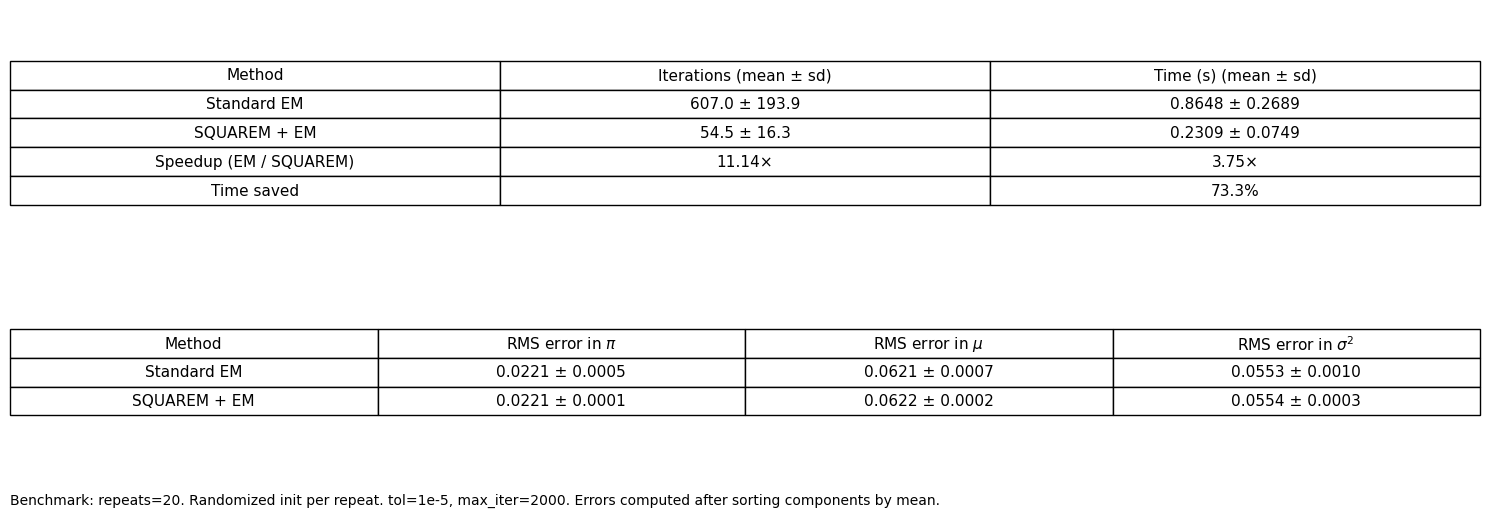

In [ ]:
# ============================================================
# Efficiency + RMS accuracy tables (20 randomly initializedrepeats)
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

def _fmt(x, d=3):
    return "NA" if np.isnan(x) else f"{x:.{d}f}"

def make_efficiency_and_accuracy_tables(results, repeats,
                                        digits_time=4,
                                        digits_iter=1,
                                        digits_err=4):
    s = results["summary"]

    # -----------------------------
    # Table 1: Computational efficiency
    # -----------------------------
    eff_col_labels = [
        "Method",
        "Iterations (mean ± sd)",
        "Time (s) (mean ± sd)",
    ]

    eff_cell_text = [
        [
            "Standard EM",
            f"{_fmt(s['EM']['iter_mean'], digits_iter)} ± {_fmt(s['EM']['iter_sd'], digits_iter)}",
            f"{_fmt(s['EM']['time_mean'], digits_time)} ± {_fmt(s['EM']['time_sd'], digits_time)}",
        ],
        [
            "SQUAREM + EM",
            f"{_fmt(s['SQUAREM']['iter_mean'], digits_iter)} ± {_fmt(s['SQUAREM']['iter_sd'], digits_iter)}",
            f"{_fmt(s['SQUAREM']['time_mean'], digits_time)} ± {_fmt(s['SQUAREM']['time_sd'], digits_time)}",
        ],
        [
            "Speedup (EM / SQUAREM)",
            _fmt(s["speedup"]["iter_factor"], 2) + "×",
            _fmt(s["speedup"]["time_factor"], 2) + "×",
        ],
        [
            "Time saved",
            "",
            _fmt(s["speedup"]["time_saved_pct"], 1) + "%",
        ],
    ]

    # -----------------------------
    # Table 2: Accuracy (RMS errors)
    # -----------------------------
    acc_col_labels = [
        "Method",
        "RMS error in $\\pi$",
        "RMS error in $\\mu$",
        "RMS error in $\\sigma^2$",
    ]

    acc_cell_text = [
        [
            "Standard EM",
            f"{_fmt(s['EM']['rms_pi_mean'], digits_err)} ± {_fmt(s['EM']['rms_pi_sd'], digits_err)}",
            f"{_fmt(s['EM']['rms_mu_mean'], digits_err)} ± {_fmt(s['EM']['rms_mu_sd'], digits_err)}",
            f"{_fmt(s['EM']['rms_var_mean'], digits_err)} ± {_fmt(s['EM']['rms_var_sd'], digits_err)}",
        ],
        [
            "SQUAREM + EM",
            f"{_fmt(s['SQUAREM']['rms_pi_mean'], digits_err)} ± {_fmt(s['SQUAREM']['rms_pi_sd'], digits_err)}",
            f"{_fmt(s['SQUAREM']['rms_mu_mean'], digits_err)} ± {_fmt(s['SQUAREM']['rms_mu_sd'], digits_err)}",
            f"{_fmt(s['SQUAREM']['rms_var_mean'], digits_err)} ± {_fmt(s['SQUAREM']['rms_var_sd'], digits_err)}",
        ],
    ]

    # -----------------------------
    # Figure with two stacked tables
    # -----------------------------
    fig, axes = plt.subplots(
        nrows=2, ncols=1,
        figsize=(15, 5.2),
        gridspec_kw={"height_ratios": [1.1, 0.9]}
    )

    for ax in axes:
        ax.axis("off")

    # Efficiency table
    table_eff = axes[0].table(
        cellText=eff_cell_text,
        colLabels=eff_col_labels,
        cellLoc="center",
        loc="center",
    )
    table_eff.auto_set_font_size(False)
    table_eff.set_fontsize(11)
    table_eff.scale(1, 1.4)

    # Accuracy table
    table_acc = axes[1].table(
        cellText=acc_cell_text,
        colLabels=acc_col_labels,
        cellLoc="center",
        loc="center",
    )
    table_acc.auto_set_font_size(False)
    table_acc.set_fontsize(11)
    table_acc.scale(1, 1.4)

    # -----------------------------
    # Shared benchmark footnote
    # -----------------------------
    fig.text(
        0.01, 0.02,
        f"Benchmark: repeats={repeats}. Randomized init per repeat. "
        f"tol=1e-5, max_iter=2000. "
        f"Errors computed after sorting components by mean.",
        fontsize=10
    )

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()


# -----------------------------
# Run (after benchmarking)
# -----------------------------
make_efficiency_and_accuracy_tables(bench_rand, repeats=repeats)


# Parametric Bootstrap and percentile Confidence Intervals
Note: This works for both Standard EM and SQUAREM accelerated EM since parametric bootstrap depends only on the parameters we have converged to rather than the optimization path


In [140]:
# ============================================================
# Parametric bootstrap for 1D GMM + percentile CIs + simple plots
# Works for both standard EM and SQUAREM (pass different fit_fn + theta_hat)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

def simulate_from_fitted_gmm(n, pi_hat, mu_hat, var_hat, rng):
    """Simulate n points from a fitted 1D Gaussian mixture."""
    K = len(pi_hat)
    z = rng.choice(K, size=n, p=pi_hat)
    y = rng.normal(loc=mu_hat[z], scale=np.sqrt(var_hat[z]), size=n)
    return y

def align_components_by_mean(pi, mu, var):
    """Sort components by mean to reduce label switching across refits."""
    order = np.argsort(mu)
    return pi[order], mu[order], var[order]

def percentile_ci(samples, alpha=0.05):
    """Percentile CI: [q_{alpha/2}, q_{1-alpha/2}]"""
    L = np.quantile(samples, alpha / 2.0)
    U = np.quantile(samples, 1.0 - alpha / 2.0)
    return float(L), float(U)

def fmt_ci(ci):
    return f"[{ci[0]:.4f}, {ci[1]:.4f}]"

# ---- wrappers around existing solvers ----
def fit_em(y):
    K = 3
    mu_init   = np.array([-1.0, 0.0, 1.0])
    var_init  = np.array([1.0, 1.0, 1.0])
    prop_init = np.array([1/3, 1/3, 1/3])

    out = em_gmm_1d(
        y=y, K=K,
        mu_init=mu_init, var_init=var_init, prop_init=prop_init,
        tol=1e-5, max_iter=2000
    )
    return {"prop": out["prop"], "means": out["means"], "vars": out["vars"]}

def fit_squarem_em(y):
    K = 3
    mu_init   = np.array([-1.0, 0.0, 1.0])
    var_init  = np.array([1.0, 1.0, 1.0])
    prop_init = np.array([1/3, 1/3, 1/3])

    out = squarem_gmm_1d(
        y=y, K=K,
        mu_init=mu_init, var_init=var_init, prop_init=prop_init,
        tol=1e-5, max_iter=2000
    )
    return {"prop": out["prop"], "means": out["means"], "vars": out["vars"]}

def _plot_cis(point_est, ci_list, title, y_label):
    """
    Simple CI plot: one point per component with vertical error bars.
    point_est: (K,)
    ci_list: list of length K with (L, U)
    """
    K = len(point_est)
    x = np.arange(1, K + 1)
    L = np.array([ci[0] for ci in ci_list])
    U = np.array([ci[1] for ci in ci_list])

    # asymmetric error bars: lower = point - L, upper = U - point
    yerr = np.vstack([point_est - L, U - point_est])

    plt.figure()
    plt.errorbar(x, point_est, yerr=yerr, fmt='o', capsize=5)
    plt.xticks(x, [f"k={k}" for k in range(K)])
    plt.xlabel("Component")
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

def parametric_bootstrap_gmm(
    fit_fn,
    theta_hat,
    B=200,
    alpha=0.05,
    rng=None,
    n=None,
    verbose=False,
    make_plots=True,
    method_name=None,
):
    """
    Parametric bootstrap for a fitted 1D GMM.

    Steps:
      - Align theta_hat by mean (label consistency)
      - For b=1..B:
           simulate Y* ~ GMM(theta_hat)
           refit theta*(b)
           align theta*(b)
      - Percentile CIs from bootstrap draws
       plot CIs for pi, mu, var

    Returns a dict with bootstrap arrays + CIs.
    """
    if rng is None:
        rng = np.random.default_rng(2025)
    if n is None:
        n = len(Y)

    # pull out and align theta_hat
    pi_hat = np.asarray(theta_hat["prop"], dtype=float)
    mu_hat = np.asarray(theta_hat["means"], dtype=float)
    var_hat = np.asarray(theta_hat["vars"], dtype=float)

    pi_hat, mu_hat, var_hat = align_components_by_mean(pi_hat, mu_hat, var_hat)
    K = len(pi_hat)

    boot_pi  = np.zeros((B, K))
    boot_mu  = np.zeros((B, K))
    boot_var = np.zeros((B, K))

    for b in range(B):
        if verbose and (b % 20 == 0):
            print(f"Bootstrap {b}/{B}")

        Y_star = simulate_from_fitted_gmm(n, pi_hat, mu_hat, var_hat, rng)
        theta_star = fit_fn(Y_star)

        pi_s = np.asarray(theta_star["prop"], dtype=float)
        mu_s = np.asarray(theta_star["means"], dtype=float)
        var_s = np.asarray(theta_star["vars"], dtype=float)

        pi_s, mu_s, var_s = align_components_by_mean(pi_s, mu_s, var_s)

        boot_pi[b]  = pi_s
        boot_mu[b]  = mu_s
        boot_var[b] = var_s

    ci_pi  = [percentile_ci(boot_pi[:, k],  alpha=alpha) for k in range(K)]
    ci_mu  = [percentile_ci(boot_mu[:, k],  alpha=alpha) for k in range(K)]
    ci_var = [percentile_ci(boot_var[:, k], alpha=alpha) for k in range(K)]

    if method_name is None:
        method_name = "EM" if (fit_fn is fit_em) else "SQUAREM+EM"

    level = 1.0 - alpha
    print(f"\n{method_name} percentile bootstrap CIs (level={level:.0%}, B={B})")

    print("\nMixing proportions π_k:")
    for k in range(K):
        print(f"  k={k}: pi_hat={pi_hat[k]:.4f}, CI={fmt_ci(ci_pi[k])}")

    print("\nMeans μ_k:")
    for k in range(K):
        print(f"  k={k}: mu_hat={mu_hat[k]:.4f}, CI={fmt_ci(ci_mu[k])}")

    print("\nVariances σ_k^2:")
    for k in range(K):
        print(f"  k={k}: var_hat={var_hat[k]:.4f}, CI={fmt_ci(ci_var[k])}")

    if make_plots:
        _plot_cis(pi_hat, ci_pi,  f"{method_name}: Bootstrap percentile CIs for π", "π")
        _plot_cis(mu_hat, ci_mu,  f"{method_name}: Bootstrap percentile CIs for μ", "μ")
        _plot_cis(var_hat, ci_var, f"{method_name}: Bootstrap percentile CIs for σ²", "σ²")

    return {
        "method": method_name,
        "B": B,
        "alpha": alpha,
        "theta_hat_aligned": {"prop": pi_hat, "means": mu_hat, "vars": var_hat},
        "boot": {"pi": boot_pi, "mu": boot_mu, "var": boot_var},
        "ci": {"pi": ci_pi, "mu": ci_mu, "var": ci_var},
    }

In [142]:
# -----------------------------
# Run bootstrap for STANDARD EM
# -----------------------------
theta_hat_em = {"prop": fit["prop"], "means": fit["means"], "vars": fit["vars"]}

boot_em = parametric_bootstrap_gmm(
    fit_fn=fit_em,
    theta_hat=theta_hat_em,
    B=200,
    alpha=0.05,
    rng=np.random.default_rng(2025),
    n=len(Y),
    verbose=True,
    make_plots=False,
    method_name="Standard EM",
)

Bootstrap 0/200
Bootstrap 20/200
Bootstrap 40/200
Bootstrap 60/200
Bootstrap 80/200
Bootstrap 100/200
Bootstrap 120/200
Bootstrap 140/200
Bootstrap 160/200
Bootstrap 180/200

Standard EM percentile bootstrap CIs (level=95%, B=200)

Mixing proportions π_k:
  k=0: pi_hat=0.2567, CI=[0.2269, 0.2785]
  k=1: pi_hat=0.3195, CI=[0.2721, 0.3819]
  k=2: pi_hat=0.4238, CI=[0.3858, 0.4614]

Means μ_k:
  k=0: mu_hat=-2.0044, CI=[-2.1237, -1.9116]
  k=1: mu_hat=-0.0677, CI=[-0.1352, 0.0069]
  k=2: mu_hat=1.9145, CI=[1.8075, 2.0337]

Variances σ_k^2:
  k=0: var_hat=0.6315, CI=[0.5330, 0.7092]
  k=1: var_hat=0.4220, CI=[0.3304, 0.5656]
  k=2: var_hat=0.8799, CI=[0.7859, 0.9865]


In [143]:
# ============================================================
# Run bootstrap for SQUAREM + EM
# ============================================================

theta_hat_sq = {"prop": fit_sq["prop"], "means": fit_sq["means"], "vars": fit_sq["vars"]}

boot_sq = parametric_bootstrap_gmm(
    fit_fn=fit_squarem_em,
    theta_hat=theta_hat_sq,
    B=200,
    alpha=0.05,
    rng=np.random.default_rng(2025),
    n=len(Y),
    verbose=True,
    make_plots=False,
    method_name="SQUAREM + EM",
)


Bootstrap 0/200
Bootstrap 20/200
Bootstrap 40/200
Bootstrap 60/200
Bootstrap 80/200
Bootstrap 100/200
Bootstrap 120/200
Bootstrap 140/200
Bootstrap 160/200
Bootstrap 180/200

SQUAREM + EM percentile bootstrap CIs (level=95%, B=200)

Mixing proportions π_k:
  k=0: pi_hat=0.2565, CI=[0.2262, 0.2781]
  k=1: pi_hat=0.3200, CI=[0.2713, 0.3835]
  k=2: pi_hat=0.4235, CI=[0.3850, 0.4618]

Means μ_k:
  k=0: mu_hat=-2.0051, CI=[-2.1252, -1.9107]
  k=1: mu_hat=-0.0674, CI=[-0.1355, 0.0070]
  k=2: mu_hat=1.9155, CI=[1.8075, 2.0334]

Variances σ_k^2:
  k=0: var_hat=0.6309, CI=[0.5314, 0.7093]
  k=1: var_hat=0.4230, CI=[0.3303, 0.5687]
  k=2: var_hat=0.8791, CI=[0.7832, 0.9877]


# Additional Visualizations for report

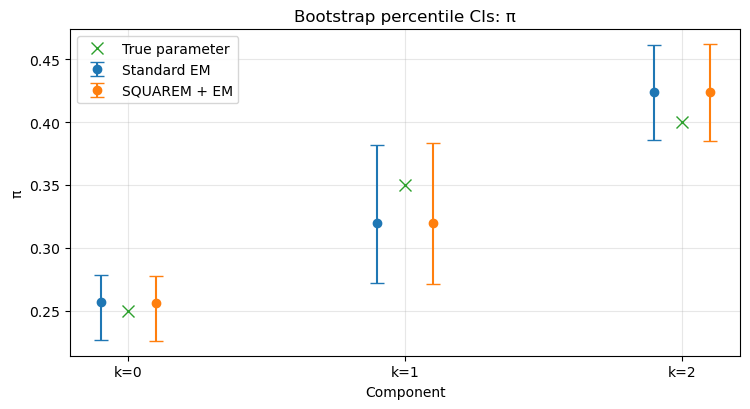

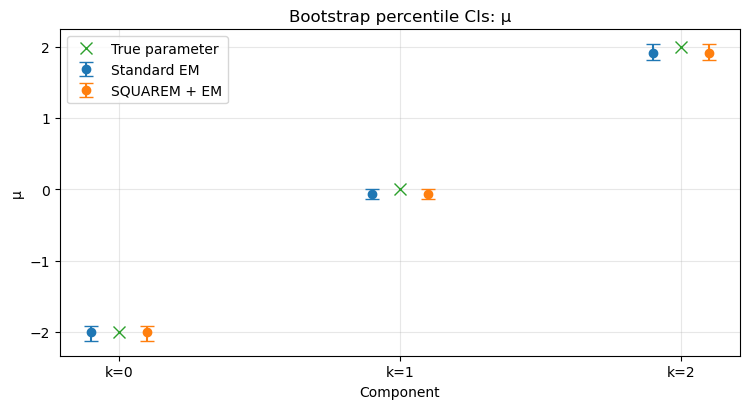

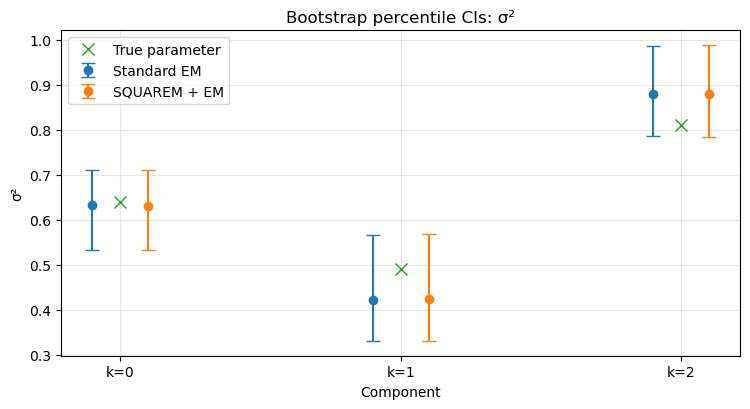

In [144]:
# ============================================================
# Side-by-side CI comparison plots: Standard EM vs SQUAREM+EM
# Assumes we already ran both bootstraps and have:
#   boot_em, boot_sq
# ============================================================


def _extract_point_and_ci(boot_res, param_key):
    """
    boot_res: dict returned by parametric_bootstrap_gmm
    param_key in {"pi","mu","var"}
    returns:
      point: (K,)
      L: (K,)
      U: (K,)
    """
    point = np.asarray(boot_res["theta_hat_aligned"][{"pi":"prop","mu":"means","var":"vars"}[param_key]])
    ci_list = boot_res["ci"][param_key]
    L = np.array([ci[0] for ci in ci_list], dtype=float)
    U = np.array([ci[1] for ci in ci_list], dtype=float)
    return point, L, U

def _aligned_true_params(param_key, true_params):
    """
    Align truth the same way you align components elsewhere: sort by TRUE means.
    true_params: dict with keys {'pi','mu','var'} where var is variance (sigma^2).
    """
    pi_t  = np.asarray(true_params["pi"], dtype=float).copy()
    mu_t  = np.asarray(true_params["mu"], dtype=float).copy()
    var_t = np.asarray(true_params["var"], dtype=float).copy()

    order = np.argsort(mu_t)
    pi_t, mu_t, var_t = pi_t[order], mu_t[order], var_t[order]

    return {"pi": pi_t, "mu": mu_t, "var": var_t}[param_key]

def plot_ci_comparison_overlay_with_truth(
    boot_em,
    boot_sq,
    param_key,
    y_label,
    true_params,
    title_prefix="",
):
    """
    Single plot overlay: EM and SQUAREM error bars + TRUE parameter markers.
    """
    p_em, L_em, U_em = _extract_point_and_ci(boot_em, param_key)
    p_sq, L_sq, U_sq = _extract_point_and_ci(boot_sq, param_key)

    K = len(p_em)
    if len(p_sq) != K:
        raise ValueError("K mismatch between methods. Ensure both fits use the same K and alignment.")

    p_true = _aligned_true_params(param_key, true_params)
    if len(p_true) != K:
        raise ValueError("K mismatch between true_params and bootstrap results.")

    x = np.arange(1, K + 1)

    yerr_em = np.vstack([p_em - L_em, U_em - p_em])
    yerr_sq = np.vstack([p_sq - L_sq, U_sq - p_sq])

    # horizontal jitter so error bars don't overlap perfectly
    dx = 0.10

    plt.figure(figsize=(7.6, 4.2))
    plt.errorbar(x - dx, p_em, yerr=yerr_em, fmt='o', capsize=5, label="Standard EM")
    plt.errorbar(x + dx, p_sq, yerr=yerr_sq, fmt='o', capsize=5, label="SQUAREM + EM")

    # TRUE markers (no error bars)
    plt.plot(x, p_true, marker='x', linestyle='None', markersize=8, label="True parameter")

    plt.xticks(x, [f"k={k}" for k in range(K)])
    plt.xlabel("Component")
    plt.ylabel(y_label)
    plt.title(f"{title_prefix}Bootstrap percentile CIs: {y_label}".strip())
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


#true param dict
true_params = {
    "pi":  pi_true,
    "mu":  mu_true,
    "var": sigma_true**2,
}

#create plots
plot_ci_comparison_overlay_with_truth(boot_em, boot_sq, param_key="pi",  y_label="π",  true_params=true_params)
plot_ci_comparison_overlay_with_truth(boot_em, boot_sq, param_key="mu",  y_label="μ",  true_params=true_params)
plot_ci_comparison_overlay_with_truth(boot_em, boot_sq, param_key="var", y_label="σ²", true_params=true_params)


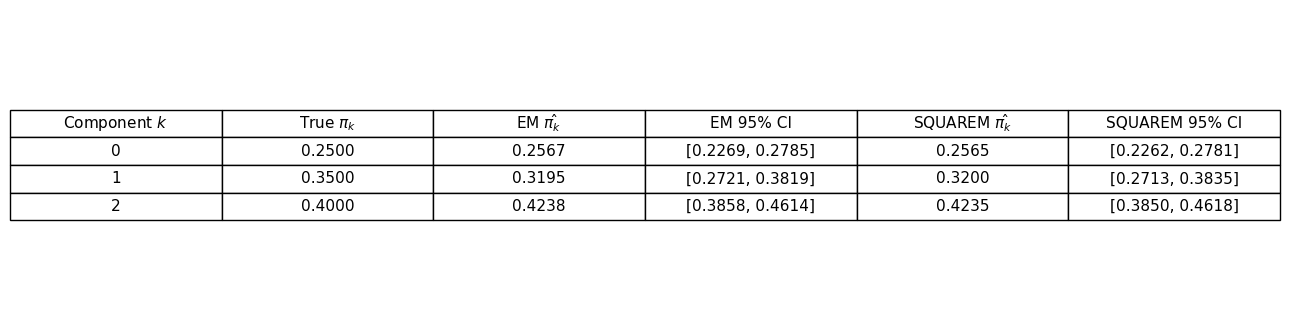

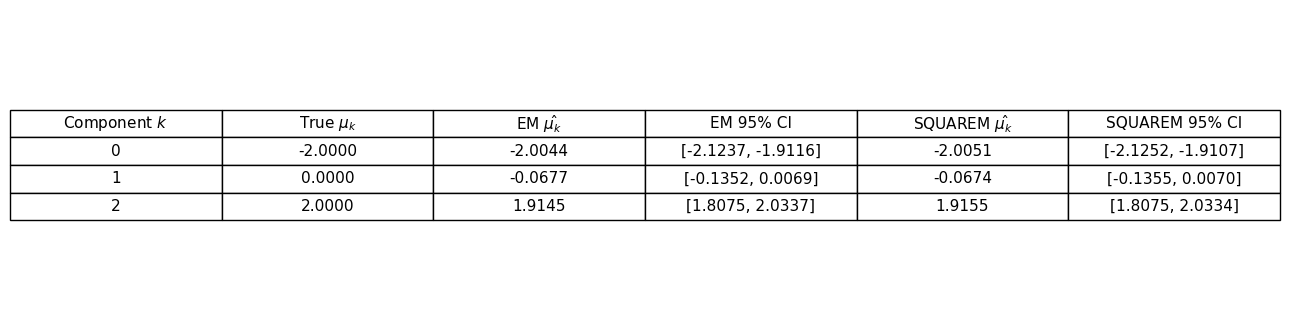

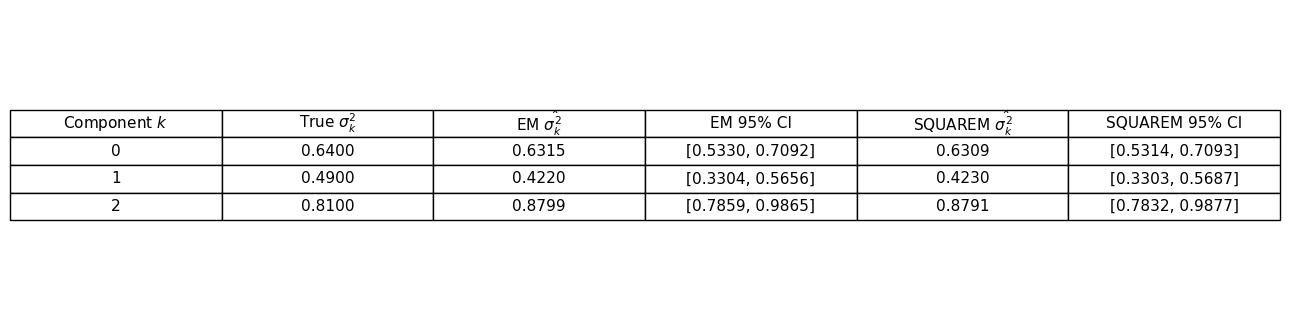

In [146]:
### CI TABLES

def _extract_for_table(boot_res, param_key):
    key_map = {"pi": "prop", "mu": "means", "var": "vars"}
    point = np.asarray(boot_res["theta_hat_aligned"][key_map[param_key]])
    ci = boot_res["ci"][param_key]
    return point, ci

def _fmt(x, d=4):
    return f"{x:.{d}f}"

def make_ci_table_with_truth(
    param_key,
    param_symbol,
    boot_em,
    boot_sq,
    true_params,
    digits=4,
):
    """
    Adds a 'True' column (aligned by mean ordering, consistent with your bootstrap alignment).

    param_key: 'pi', 'mu', or 'var'
    param_symbol: latex-ish symbol string, e.g. r'\pi_k', r'\mu_k', r'\sigma_k^2'
    true_params: dict with keys {'pi','mu','var'} each shape (K,)
                 Example:
                   true_params = {'pi': pi_true, 'mu': mu_true, 'var': sigma_true**2}
    """
    p_em, ci_em = _extract_for_table(boot_em, param_key)
    p_sq, ci_sq = _extract_for_table(boot_sq, param_key)

    K = len(p_em)
    if len(p_sq) != K:
        raise ValueError("K mismatch between boot_em and boot_sq.")

    # --- align the TRUE params in the same way (sort by true means) ---
    pi_t  = np.asarray(true_params["pi"], dtype=float).copy()
    mu_t  = np.asarray(true_params["mu"], dtype=float).copy()
    var_t = np.asarray(true_params["var"], dtype=float).copy()

    order = np.argsort(mu_t)
    pi_t, mu_t, var_t = pi_t[order], mu_t[order], var_t[order]

    true_map = {"pi": pi_t, "mu": mu_t, "var": var_t}
    p_true = true_map[param_key]
    if len(p_true) != K:
        raise ValueError("K mismatch between true_params and bootstrap results.")

    col_labels = [
        "Component $k$",
        f"True ${param_symbol}$",
        f"EM $\\hat{{{param_symbol}}}$",
        "EM 95% CI",
        f"SQUAREM $\\hat{{{param_symbol}}}$",
        "SQUAREM 95% CI",
    ]

    cell_text = []
    for k in range(K):
        cell_text.append([
            f"{k}",
            _fmt(p_true[k], digits),
            _fmt(p_em[k], digits),
            f"[{_fmt(ci_em[k][0],digits)}, {_fmt(ci_em[k][1],digits)}]",
            _fmt(p_sq[k], digits),
            f"[{_fmt(ci_sq[k][0],digits)}, {_fmt(ci_sq[k][1],digits)}]",
        ])

    fig, ax = plt.subplots(figsize=(13, 2.2 + 0.4 * K))
    ax.axis("off")

    table = ax.table(
        cellText=cell_text,
        colLabels=col_labels,
        cellLoc="center",
        loc="center",
    )

    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 1.4)

    plt.tight_layout()
    plt.show()


true_params = {
    "pi":  pi_true,
    "mu":  mu_true,
    "var": sigma_true**2,   # convert std devs to variances to match your tables
}

# -----------------------------
# Generate tables
# -----------------------------
make_ci_table_with_truth("pi",  r"\pi_k",        boot_em, boot_sq, true_params)
make_ci_table_with_truth("mu",  r"\mu_k",        boot_em, boot_sq, true_params)
make_ci_table_with_truth("var", r"\sigma_k^2",   boot_em, boot_sq, true_params)
